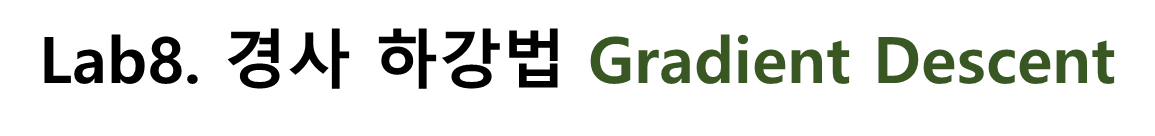

## 경사 하강법
  * 가장 적합한(best)이라 함은 최적화 문제의 답을 내는 것입니다.
    * 모델의 오류(error)를 최소화
    * 가능도(likelihood)를 최대화
  * 우리는 종종 함수 f를 최대화(또는 최소화)시키는 입력값 v를 찾아야 합니다.
  * 최적화(最適化, optimization)는 사용 가능한 몇 가지 대안 중에서 최고의 요소(어떤 기준을 고려하여)를 선택하는 것을 의미합니다.
  * 딥러닝의 최적화 목표는 손실함수/비용함수/오류함수의 값을 최소화하는 방향으로 하이퍼파라미터의 값을 찾는 것입니다.
  * 그래디언트(gradient, 경사, 기울기, 편미분 벡터)는 함수가 가장 빠르게 증가할 수 있는 방향을 나타냅니다.

### 기본 설정

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
#from linear_algebra import distance, vector_subtract, scalar_multiply

#original version
def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
   return math.sqrt(squared_distance(v, w))

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    return reduce(vector_add, vectors)

def vector_mean(vectors):
    """compute the vector whose i-th element is the mean of the
    i-th elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

## 1. 경사 하강법의 숨은 의미
  * 경사 하강법의 핵심은.
    * 미분한 결과값이 양수이면 찾고자 하는 대상의 값을 빼줘야 최소점으로 다가가고,
    * 미분한 결과값이 음수이면 찾고자 하는 대상의 값을 더해줘야 최소점으로 다가갈 수 있다는 사실입니다.

In [2]:
from functools import reduce
import math, random

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

vector = [i for i in range(10)]
sum_of_squares(vector)

np.sum(np.square(vector))

285

285

### 2. 그래디언트 계산하기
  * f가 단변수 함수인 경우, 점 x에서의 미분값(derivative)은 x가 아주 조금 변했을 때 f(x)의 변화량을 의미합니다.
  * 미분값은 함수변화율의 극한값 입니다.  
  * 미분값은 점 (x, f(x))에서의 함수와 접하는 선의 기울기를 의미 합니다.
  * (f(x+h)-f(x))/h는 점 (x+h, f(x+h))를 통과하는 기울기 이지만 함수와 완벽하게는 접하지 않습니다.
  * h의 값이 점점 작아질수록, 완벽히 접하지 않았던 선이 점점 함수와 접하게 됩니다.

### 미분값 계산 (1) f가 단변수 함수인 경우
  * 도함수를 수학식으로 구할 수 있는 경우 : 도함수(derivative)에 변수값만 대입합니다.  

In [3]:
def square(x: float) -> float:
    return x * x

def derivative(x: float) -> float:
    return 2 * x

#### 함수 변화율(미분값) 근사법 (1) f가 단변수 함수인 경우
  * 도함수를 수학식으로 구할 수 없는 경우 : 아주 작은 e 값을 대입해 미분값(=그래디언트)을 어림잡을 수 있습니다.
    * 단점은 계산 비용이 크다는 것입니다.

Text(0.5, 1.0, 'actual Derivatives vs. Estimates')

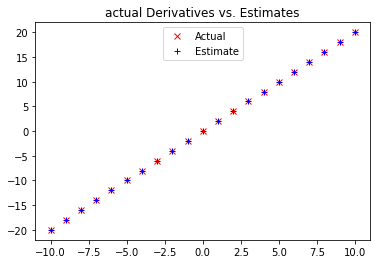

In [4]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def square(x: float) -> float:
    return x * x

def derivative(x: float) -> float:
    return 2 * x

xs = range(-10,11)
actuals = [derivative(x) for x in xs]
estimates = [difference_quotient(square, x, h=0.0001) for x in xs]

# 두 계산식의 결괏값이 거의 비슷함을 보여 주기 위한 그래프
# plot to show they're basically the same
import matplotlib.pyplot as plt    
plt.title("actual Derivatives vs. Estimates")
plt.plot(xs, actuals, 'rx', label='Actual')      # red  x
plt.plot(xs, estimates, 'b+', label='Estimate')  # blue +
plt.legend(loc=9)
plt.show()                                       # purple *, hopefully

### 미분값 계산 (2) f가 다변수 함수인 경우
  * f가 다변수 함수(a function of many variables)인 경우
    * 편도함수를 수학식으로 구할 수 있는 경우 : 편도함수(partial derivative)에 변수값만 대입합니다.

  * f가 다변수 함수(a function of many variables)인 경우
    * 편도함수를 수학식으로 구할 수 없는 경우 : 아주 작은 e값을 대입해 그래디언트의 근사값을 구할 수 있습니다.

In [5]:
def partial_difference_quotient(f, v, i, h): # v는 변수의 리스트, i는 편미분할 변수

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0) # h를 v의 i번째 변수에만 더해주자
         for j, v_j in enumerate(v)] # ex) v = [v1, v2, v3], i = 2 ... w = [v1, v2 + h, v3]

    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.0001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

#### 함수 변화율(미분값) 근사법 (2) f가 다변수 함수인 경우
  * 편도함수를 수학식으로 구할 수 없는 경우 : 아주 작은 e값을 대입해 그래디언트의 근사값을 구할 수 있습니다.

## 3. 그래디언트 적용하기
  * 경사 하강법을 이용해서 3차원 벡터의 최소값을 구해 봅니다.
    * 임의의 시작점을 잡고 그래디언트가 아주 작아질 때까지 경사의 반대 방향으로 조금씩 이동하면 됩니다.

In [6]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)] # ex) v = [v1, v2, v3], direction = gradient?

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# 임의의 시작점을 선택
v = [random.randint(-10,10) for i in range(3)]
tolerance = 0.0000001   # 아주 작은 e값

while True:
    #print v, sum_of_squares(v)
    gradient = sum_of_squares_gradient(v)   # compute the gradient at v
    next_v = step(v, gradient, -0.0001)     # take a negative gradient step
    if distance(next_v, v) < tolerance:     # stop if we're converging
        break
    v = next_v                              # continue if we're not
    #print(v)

print("minimum v", v)
print("minimum value", sum_of_squares(v))

minimum v [0.00015811350680135987, -0.0004743405204040885, 0.0]
minimum value 2.499988103302452e-07


### 적절한 이동 거리 정하기
  * 얼마만큼 이동해야 하는지(학습률) 정하는 일반적인 옵션
    1. 이동 거리를 고정
    2. 시간에 따라 이동 거리를 점차 줄임
    3. 이동할 때마다 목적 함수를 최소화하는 이동 거리로 정함(가장 이상적이나 계산 비용이 큼)

## 4. 경사 하강법으로 모델 학습
  * 데이터셋과 미분가능한 하나 이상의 파라미터로 구성된 모델이 주어질 때, 손실 함수(loss function)는 모델의 파라미터가 얼마나 좋고 나쁜지 알려주며, 경사 하강법으로 손실을 최소화하는 모델의 파라미터를 구할 수 있습니다.
  * 한 개의 데이터 포인트에서 오차의 그래디언트를 계산해 주는 함수는 아래와 같습니다.

In [7]:
# Using gradient descent to fit models

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return vector_add(v, step)

# x ranges from -50 to 49, y is always 20 * x + 5
inputs = [(x, 20 * x + 5) for x in range(-50, 50)]
print(inputs)

#def linear_gradient(x: float, y: float, theta: Vector) -> Vector:
def linear_gradient(x, y, theta):
    slope, intercept = theta
    predicted = slope * x + intercept
    error = (predicted - y)
    squared_error = error ** 2
    grad = [2 * error * x, 2 * error]
    return grad

[(-50, -995), (-49, -975), (-48, -955), (-47, -935), (-46, -915), (-45, -895), (-44, -875), (-43, -855), (-42, -835), (-41, -815), (-40, -795), (-39, -775), (-38, -755), (-37, -735), (-36, -715), (-35, -695), (-34, -675), (-33, -655), (-32, -635), (-31, -615), (-30, -595), (-29, -575), (-28, -555), (-27, -535), (-26, -515), (-25, -495), (-24, -475), (-23, -455), (-22, -435), (-21, -415), (-20, -395), (-19, -375), (-18, -355), (-17, -335), (-16, -315), (-15, -295), (-14, -275), (-13, -255), (-12, -235), (-11, -215), (-10, -195), (-9, -175), (-8, -155), (-7, -135), (-6, -115), (-5, -95), (-4, -75), (-3, -55), (-2, -35), (-1, -15), (0, 5), (1, 25), (2, 45), (3, 65), (4, 85), (5, 105), (6, 125), (7, 145), (8, 165), (9, 185), (10, 205), (11, 225), (12, 245), (13, 265), (14, 285), (15, 305), (16, 325), (17, 345), (18, 365), (19, 385), (20, 405), (21, 425), (22, 445), (23, 465), (24, 485), (25, 505), (26, 525), (27, 545), (28, 565), (29, 585), (30, 605), (31, 625), (32, 645), (33, 665), (34, 

### 경사 하강법으로 모델 학습 예
  * 평균제곱오차의 그래디언트를 모든 데이터 포인트에서 구해서 평균을 낸 다음 다음과 같이 경사 하강법을 적용 ⇰ SGD (stochastic gradient descent)
    1. 임의의 theta로 시작 Start with a random theta
    2. 모든 그래디언트의 평균을 계산 Calculate the average of all gradients
    3. theta를 2번에서 계산된 값으로 변경 Change theta to the value calculated in step 2.
    4. 반복 repeat
  * 스토캐스틱 : 확률적인, 확률과정의, 그러나까 확률뷴포모델에 따른다는 뜻입니다.
  * 전체 데이터셋을 한 번 훑어본다는 의미의 에폭(epoch)을 여러 번 수행하면 올바른 경사와 절편이 학습됩니다.

In [8]:
#from linear_algebra import vector_mean

# Start with random values for slope and intercept
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

learning_rate = .001

for epoch in range(5000):
    # Computer the mean of the gradients
    grad = vector_mean([linear_gradient(x, y, theta) for x, y in inputs])
    # Take a step in that direction
    theta = gradient_step(theta, grad, -learning_rate)
    print(epoch, theta)
slope, intercept = theta
assert 19.9 < slope < 20.1, "slope should be about 20"
assert 4.9 < intercept < 5.1, "intercept should be about 5"

0 [33.98303676418639, -0.512444376235915]
1 [10.66780203391145, -0.4874364507192566]
2 [26.21908860693034, -0.4857937757839066]
3 [15.846382105401677, -0.46860309962540847]
4 [22.764994532597452, -0.46181951132075605]
5 [18.150286827246177, -0.44813087776551713]
6 [21.228310555349033, -0.43908432918274]
7 [19.17527777525301, -0.4269778499690255]
8 [20.54466274605627, -0.4169486164938344]
9 [19.631292999763975, -0.40557005651479044]
10 [20.240521999100913, -0.3951276234019969]
11 [19.83417669897629, -0.384096846156092]
12 [20.105220044936658, -0.37349447576480355]
13 [19.924444735551486, -0.3626422667683373]
14 [20.045032719120393, -0.3519925374992491]
15 [19.9646111838092, -0.3412435197051302]
16 [20.018263096879558, -0.33059642148191076]
17 [19.982487917959855, -0.3199169655420674]
18 [20.006360641755236, -0.30929464369302334]
19 [19.990448157305565, -0.298669693763882]
20 [20.001072409383426, -0.2880819062190487]
21 [19.993996621035038, -0.27750466999722717]
22 [19.99872674909963, -0

828 [19.999369664004515, 3.9504901889359396]
829 [19.999370924297924, 3.952588578222072]
830 [19.999372182071507, 3.954682771989926]
831 [19.999373437330295, 3.9567727786280176]
832 [19.99937469007932, 3.958858606508092]
833 [19.9993759403236, 3.960940263985155]
834 [19.999377188068145, 3.963017759397508]
835 [19.999378433317943, 3.9650911010667813]
836 [19.999379676078, 3.9671602972979656]
837 [19.99938091635327, 3.9692253563794475]
838 [19.999382154148748, 3.971286286583042]
839 [19.99938338946937, 3.9733430961640246]
840 [19.999384622320097, 3.975395793361166]
841 [19.999385852705856, 3.9774443863967637]
842 [19.99938708063159, 3.979488883476676]
843 [19.999388306102208, 3.9815292927903543]
844 [19.999389529122617, 3.9835656225108758]
845 [19.999390749697724, 3.985597880794977]
846 [19.999391967832413, 3.9876260757830844]
847 [19.999393183531563, 3.9896502155993505]
848 [19.999394396800046, 3.9916703083516833]
849 [19.99939560764272, 3.99368636213178]
850 [19.999396816064436, 3.9956

1831 [19.99991532266842, 4.859012192067414]
1832 [19.99991549197223, 4.859294083005948]
1833 [19.99991566093753, 4.859575410331908]
1834 [19.999915829565, 4.859856175172182]
1835 [19.999915997855318, 4.860136378651403]
1836 [19.999916165809154, 4.860416021891956]
1837 [19.999916333427187, 4.8606951060139805]
1838 [19.99991650071008, 4.86097363213538]
1839 [19.999916667658514, 4.861251601371819]
1840 [19.999916834273144, 4.8615290148367345]
1841 [19.99991700055465, 4.861805873641334]
1842 [19.99991716650369, 4.862082178894606]
1843 [19.999917332120933, 4.86235793170332]
1844 [19.99991749740704, 4.862633133172034]
1845 [19.999917662362677, 4.862907784403097]
1846 [19.999917826988497, 4.863181886496654]
1847 [19.99991799128517, 4.863455440550649]
1848 [19.999918155253344, 4.863728447660833]
1849 [19.99991831889368, 4.864000908920764]
1850 [19.999918482206837, 4.864272825421817]
1851 [19.99991864519346, 4.86454419825318]
1852 [19.999918807854215, 4.864815028501867]
1853 [19.99991897018974,

2837 [19.999988692811637, 4.981173524583132]
2838 [19.99998871541922, 4.981211166226777]
2839 [19.999988737981607, 4.9812487326097425]
2840 [19.99998876049888, 4.981286223882504]
2841 [19.99998878297113, 4.981323640195238]
2842 [19.999988805398452, 4.981360981697819]
2843 [19.999988827780932, 4.981398248539821]
2844 [19.99998885011866, 4.981435440870523]
2845 [19.999988872411727, 4.981472558838901]
2846 [19.999988894660216, 4.9815096025936345]
2847 [19.99998891686423, 4.981546572283108]
2848 [19.999988939023844, 4.981583468055406]
2849 [19.999988961139152, 4.981620290058319]
2850 [19.999988983210244, 4.981657038439342]
2851 [19.999989005237207, 4.981693713345673]
2852 [19.999989027220128, 4.981730314924219]
2853 [19.999989049159097, 4.981766843321591]
2854 [19.999989071054202, 4.981803298684107]
2855 [19.99998909290553, 4.981839681157793]
2856 [19.99998911471317, 4.981875990888383]
2857 [19.999989136477204, 4.9819122280213195]
2858 [19.999989158197728, 4.981948392701754]
2859 [19.99998

3890 [19.999998625673836, 4.997711746110152]
3891 [19.99999862842166, 4.9977163212436055]
3892 [19.999998631163997, 4.99772088722954]
3893 [19.999998633900844, 4.997725444086245]
3894 [19.999998636632224, 4.9977299918319735]
3895 [19.99999863935814, 4.997734530484942]
3896 [19.999998642078605, 4.99773906006333]
3897 [19.999998644793635, 4.997743580585282]
3898 [19.99999864750323, 4.997748092068905]
3899 [19.999998650207417, 4.997752594532271]
3900 [19.999998652906186, 4.9977570879934134]
3901 [19.99999865559957, 4.997761572470333]
3902 [19.99999865828756, 4.997766047980992]
3903 [19.999998660970178, 4.997770514543317]
3904 [19.999998663647435, 4.9977749721752005]
3905 [19.999998666319335, 4.9977794208944974]
3906 [19.9999986689859, 4.997783860719028]
3907 [19.999998671647123, 4.997788291666575]
3908 [19.999998674303036, 4.997792713754889]
3909 [19.99999867695363, 4.997797127001682]
3910 [19.99999867959893, 4.997801531424632]
3911 [19.99999868223894, 4.997805927041382]
3912 [19.99999868

4894 [19.99999981574653, 4.9996932178637215]
4895 [19.99999981611493, 4.99969383124374]
4896 [19.999999816482585, 4.999694443397368]
4897 [19.999999816849513, 4.999695054327056]
4898 [19.999999817215702, 4.999695664035251]
4899 [19.999999817581163, 4.999696272524396]
4900 [19.999999817945888, 4.999696879796929]
4901 [19.999999818309888, 4.999697485855281]
4902 [19.99999981867316, 4.99969809070188]
4903 [19.999999819035704, 4.999698694339149]
4904 [19.999999819397523, 4.999699296769506]
4905 [19.99999981975862, 4.999699897995365]
4906 [19.999999820118994, 4.999700498019132]
4907 [19.99999982047865, 4.999701096843213]
4908 [19.999999820837584, 4.999701694470006]
4909 [19.999999821195804, 4.9997022909019035]
4910 [19.9999998215533, 4.9997028861412955]
4911 [19.99999982191009, 4.999703480190567]
4912 [19.99999982226616, 4.999704073052095]
4913 [19.999999822621522, 4.999704664728258]
4914 [19.99999982297617, 4.999705255221422]
4915 [19.999999823330114, 4.999705844533955]
4916 [19.9999998236

### cf)  미니 배치 경사 하강법 MGD와 확률적 경사하강법 SGD
  * 확률적 경사 하강법의 단점은 데이터셋 전체의 그레디언트를 모두 구해야 이동 거리만큼 파라미터를 업데이트 할 수 있다는 점입니다.
  * 미니 배치 경사 하강법(mini batch gradient descent)은 데이터셋의 일부 샘플인 미니배치에 대해서만 그래디언트를 계산합니다.

In [9]:
# Minibatch and Stochastic Gradient Descent
from typing import TypeVar, List, Iterator

T = TypeVar('T')  # this allows us to type "generic" functions

def minibatches(dataset: List[T],
                batch_size: int,
                shuffle: bool = True) -> Iterator[List[T]]:
    """Generates `batch_size`-sized minibatches from the dataset"""
    # start indexes 0, batch_size, 2 * batch_size, ...
    batch_starts = [start for start in range(0, len(dataset), batch_size)]

    if shuffle: random.shuffle(batch_starts)  # shuffle the batches

    for start in batch_starts:
        end = start + batch_size
        yield dataset[start:end]

theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(1000):
    for batch in minibatches(inputs, batch_size = 20):
        grad = vector_mean([linear_gradient(x, y, theta) for x, y in batch])
        theta = gradient_step(theta, grad, -learning_rate)
    print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1, "slope should be about 20"
assert 4.9 < intercept < 5.1, "intercept should be about 5"

0 [18.660225094714182, 1.1989117770485842]
1 [19.766278006641627, 1.1014797597283825]
2 [20.22833112254388, 1.1385358218388257]
3 [19.093759720284424, 1.1936133972650764]
4 [19.88796088978044, 1.151507154031923]
5 [19.99340823370573, 1.315148168304905]
6 [20.00983065214542, 1.3378246566147662]
7 [21.454474229334743, 1.4315480154347964]
8 [19.932432388695133, 1.3785013018855021]
9 [19.78319650170342, 1.3889252028149128]
10 [20.0196469096998, 1.4119635658235439]
11 [19.643000214510028, 1.4470329019902728]
12 [19.814583152835358, 1.4765981355008204]
13 [19.78617965754604, 1.4839010420264336]
14 [20.03523663748058, 1.5105497027142218]
15 [20.005760322972822, 1.5317852469034028]
16 [19.96073545450819, 1.5421775988490656]
17 [20.517695615239074, 1.5958500279982446]
18 [19.91242342337796, 1.753312330333025]
19 [19.956219414526537, 1.7575892612451407]
20 [19.892920857414794, 1.7847123182984397]
21 [19.97877376322093, 1.7883657692006862]
22 [20.08773892270737, 1.8166324974412393]
23 [18.6481226

788 [19.999991684649835, 4.999922261650796]
789 [19.9999959063816, 4.999922932034936]
790 [20.000001854220095, 4.99992378530551]
791 [20.000005460097874, 4.9999240009721415]
792 [19.99999736309367, 4.999923725101516]
793 [20.00000119255604, 4.999924224209971]
794 [20.00000526882844, 4.999924506796164]
795 [19.99998246965199, 4.999925619299576]
796 [19.99999624349198, 4.999924564583559]
797 [19.999996773977124, 4.999924598627121]
798 [19.99999991376337, 4.999927874595346]
799 [20.000010836478744, 4.999929109266264]
800 [20.00000281021488, 4.999928935112939]
801 [19.999996864606498, 4.999929080486784]
802 [20.00001130824449, 4.99992981124333]
803 [19.999998366595072, 4.99993336970079]
804 [20.000004206680117, 4.99993361977019]
805 [19.99999960562362, 4.999934070028801]
806 [19.99999915251441, 4.999934228878117]
807 [19.9999922320509, 4.999934896720302]
808 [20.000003412838137, 4.999935623135526]
809 [20.000004752522926, 4.99993577418372]
810 [19.999972908298098, 4.999937339743907]
811 [1